# Stock:HDFC

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define stock symbol and time range
symbol = "HDFCBANK.NS"
today = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=5500)).strftime('%Y-%m-%d')

# Fetch stock data
stock_data = yf.download(symbol, start=start_date, end=today, interval="1d")

# Save or append new data
stock_data.to_csv("stock_prices.csv", mode='w', header=True)  # Overwrites existing fill

[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd
df = pd.read_csv("stock_prices.csv")
len(df)

3719

CNN+LSTM

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0318 - val_loss: 5.3240e-04 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 2.6208e-04 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6109e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9331e-04 - val_loss: 2.5494e-04 - learning_rate: 0.0010
Epoch 5/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8347e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8360e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2085e-04 - val_loss: 2.2103e-04 - learning_rate: 5.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7086e-04 - val_loss: 3.7722e-04 - learning_rate: 5.0000e-04
Epoch 8/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

Testing Results:
MAE: 17.6448, MSE: 549.7847, R² Score: 0.9693


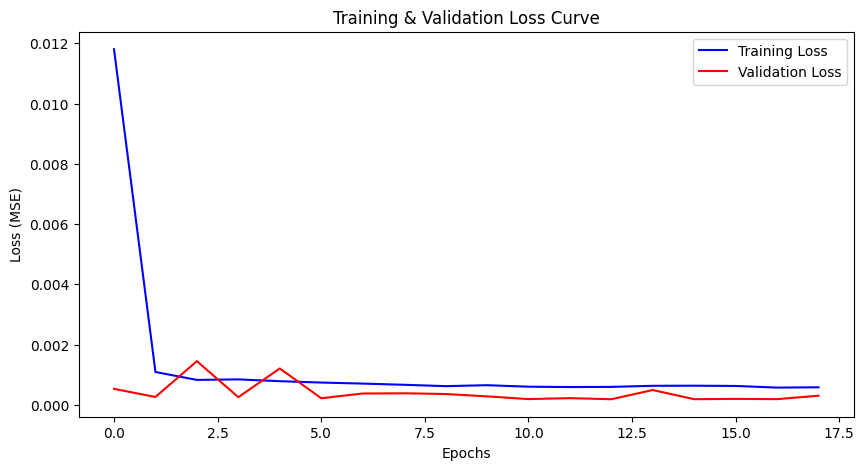

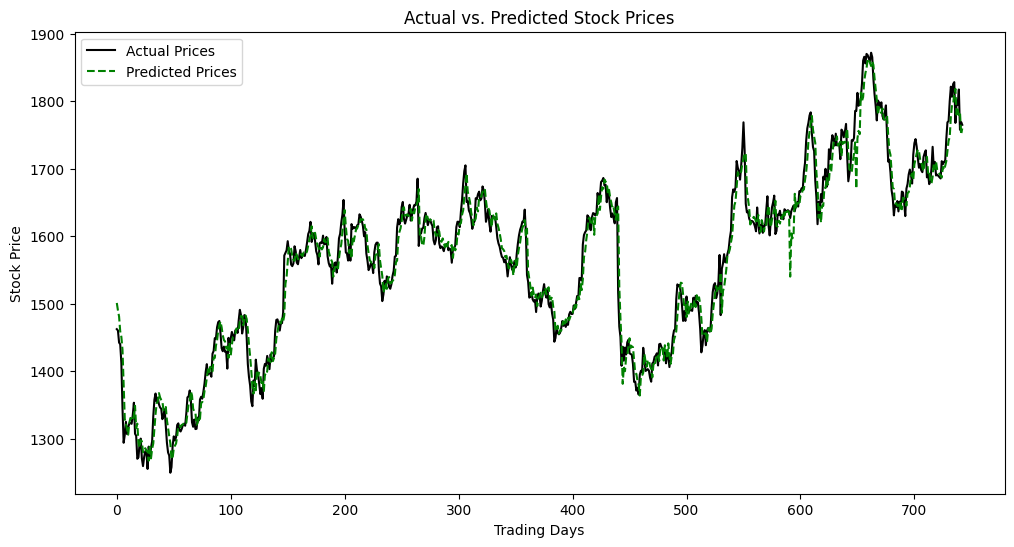

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences
timesteps = 5
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Optimized Model Architecture
model = Sequential([
    Input(shape=(timesteps, X_train.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation="relu"),
    LSTM(64, return_sequences=False),
    Dropout(0.2),  # Slightly reduced dropout
    Dense(1)
])

# Compile Model (Reverted to MSE Loss and Increased Learning Rate)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,  # Reverted batch_size to 32
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_first_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_first_test = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_test:.4f}")

# Save Model
model.save("optimized_cnn_lstm_stock_prediction_v2.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Time Period

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X_raw = df[features].values
y_raw = df[target].values

# Scale
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, x):
        score = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        weights = Softmax(axis=1)(score)
        context = Multiply()([x, weights])
        return tf.reduce_sum(context, axis=1)

# Build model function
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    cnn = Conv1D(64, 2, activation="relu")(inputs)
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)
    att = Attention()(bilstm)
    dense1 = Dense(50, activation="relu")(att)
    drop = Dropout(0.3)(dense1)
    output = Dense(1)(drop)
    model = Model(inputs, output)
    model.compile(optimizer=RMSprop(0.0005), loss="mse")
    return model

# Try different timesteps
for timestep in [5, 10, 15, 20, 25, 30]:
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - timestep):
        X_seq.append(X_scaled[i:i+timestep])
        y_seq.append(y_scaled[i + timestep])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    model = build_model((timestep, X_train.shape[2]))
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"Timestep: {timestep} | R²: {r2:.4f} | MAE: {mae:.2f} | MSE: {mse:.2f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Timestep: 5 | R²: 0.7464 | MAE: 86.24 | MSE: 13212.68
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Timestep: 10 | R²: 0.2311 | MAE: 165.92 | MSE: 40051.29
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Timestep: 15 | R²: 0.6781 | MAE: 104.28 | MSE: 16756.60
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Timestep: 20 | R²: 0.4757 | MAE: 132.61 | MSE: 27284.14
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Timestep: 25 | R²: 0.5670 | MAE: 125.26 | MSE: 22519.79
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Timestep: 30 | R²: 0.3368 | MAE: 149.67 | MSE: 34467.79


CNN+BiLSTM+Attention

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1584 - val_loss: 0.1310 - learning_rate: 5.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0664 - val_loss: 0.0687 - learning_rate: 5.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0481 - val_loss: 0.0525 - learning_rate: 5.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0352 - val_loss: 0.0409 - learning_rate: 5.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0264 - val_loss: 0.0335 - learning_rate: 5.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0210 - val_loss: 0.0360 - learning_rate: 5.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0169 - val_loss: 0.0212 - learning_rate: 5.0000e-04
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - val_loss: 0.0181 - learning_rate: 5.0000e-04
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0240 - learning

Testing Results:
MAE: 57.4165, MSE: 4773.3572, R² Score: 0.7336


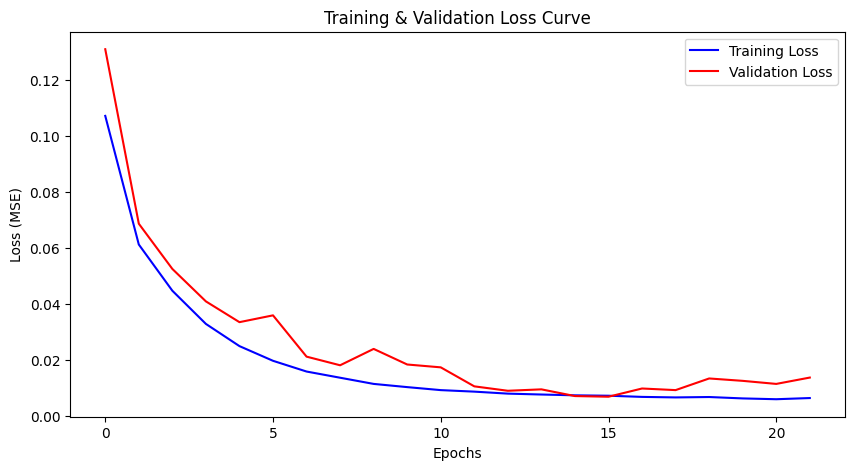

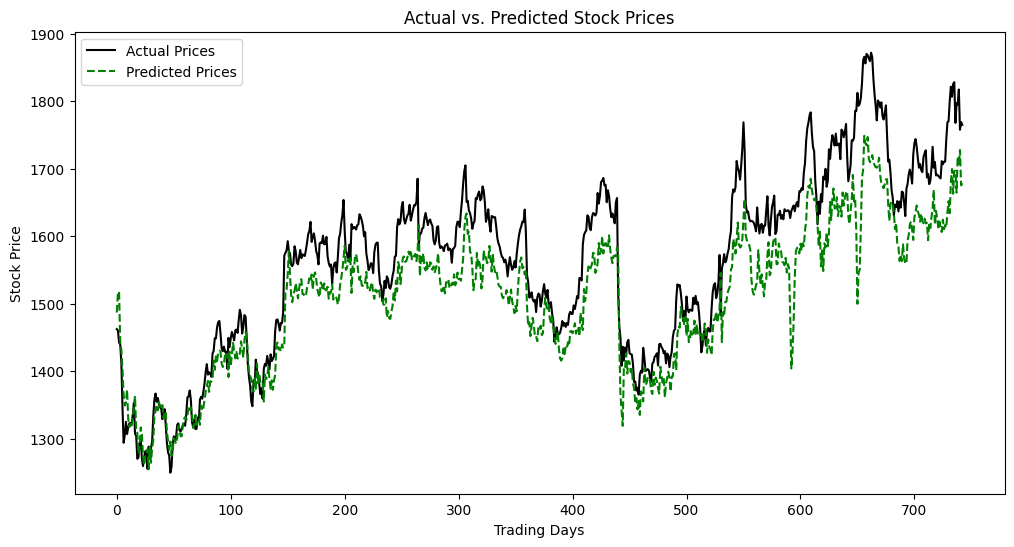

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data (Use RobustScaler to handle outliers)
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 5
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Attention Layer Function
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accepts trainable, dtype, etc.
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = Softmax(axis=1)(score)
        context_vector = Multiply()([inputs, attention_weights])
        return tf.reduce_sum(context_vector, axis=1)

# Build the Hybrid CNN + BiLSTM + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu", kernel_regularizer=l2(0.001))(inputs)

# BiLSTM Layer (Captures long-term dependencies in both directions)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Layer (Focus on important time steps)
attention = Attention()(bilstm)

# Fully Connected Layers
dense1 = Dense(50, activation="relu", kernel_regularizer=l2(0.001))(attention)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model (Using RMSprop optimizer for stability)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_second_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_second = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second:.4f}")

# Save Model
model.save("hybrid_cnn_bilstm_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Transformer + CNN + LSTM Model

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0292 - val_loss: 0.0116 - learning_rate: 5.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - val_loss: 0.0115 - learning_rate: 5.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0097 - learning_rate: 5.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.0155 - learning_rate: 5.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0029 - learning_rate: 5.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0050 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 8/100
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - va

Testing Results:
MAE: 57.6311, MSE: 5710.9752, R² Score: 0.6813


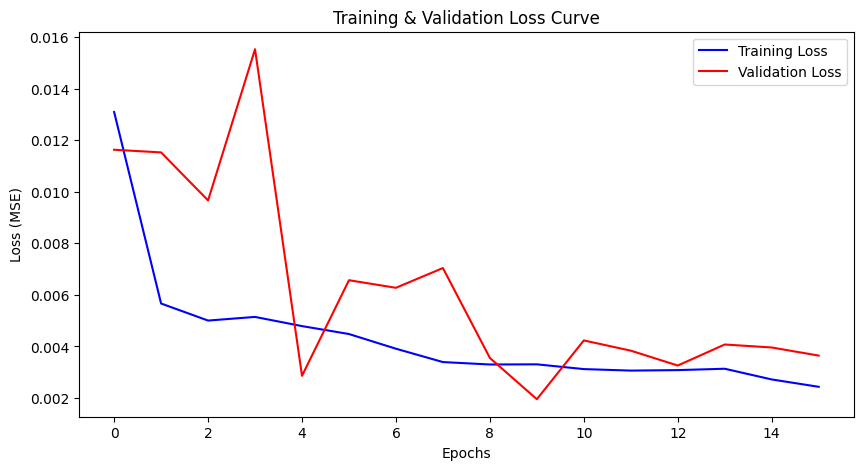

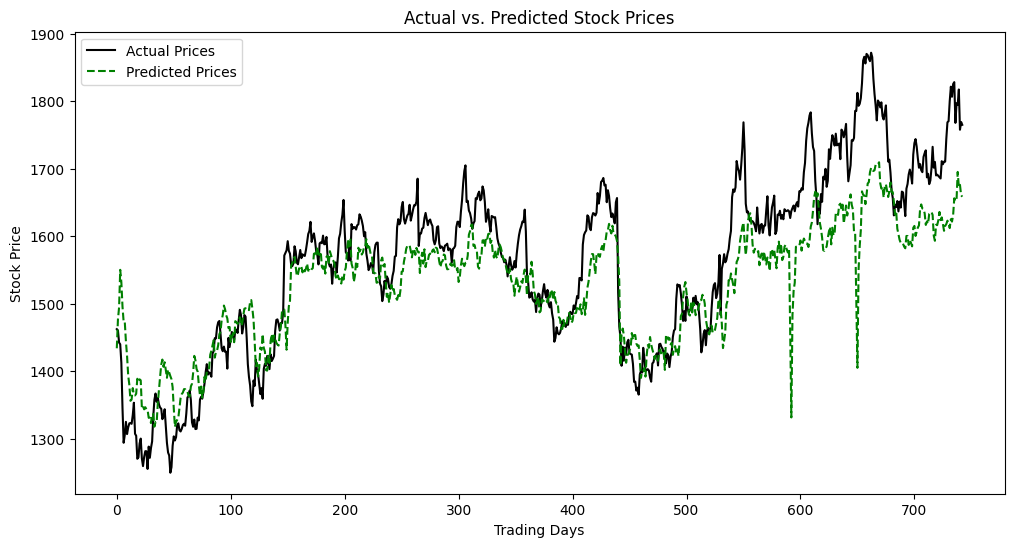

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 5
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=2, ff_dim=64):
    """Transformer Encoder Block"""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    return LayerNormalization()(ffn_output)

# Build the Hybrid Transformer + CNN + LSTM Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term features)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu")(inputs)

# Transformer Encoder Layer
transformer = transformer_encoder(cnn)

# LSTM Layer (Captures long-term dependencies)
lstm = LSTM(64, return_sequences=False)(transformer)

# Fully Connected Layers
dense1 = Dense(50, activation="relu")(lstm)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_third_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third_train:.4f}")

# Predictions & Evaluation test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_third = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third:.4f}")

# Save Model
model.save("hybrid_transformer_cnn_lstm_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

CNN + Bi-GRU + Attention Model

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0408 - val_loss: 3.0329e-04 - learning_rate: 3.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012 - learning_rate: 3.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 2.7653e-04 - learning_rate: 3.0000e-04
Epoch 4/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 6.5612e-04 - learning_rate: 1.5000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0012 - learning_rate: 1.5000e-04
Epoch 7/100
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/ste

Testing Results:
MAE: 21.3557, MSE: 809.6529, R² Score: 0.9548


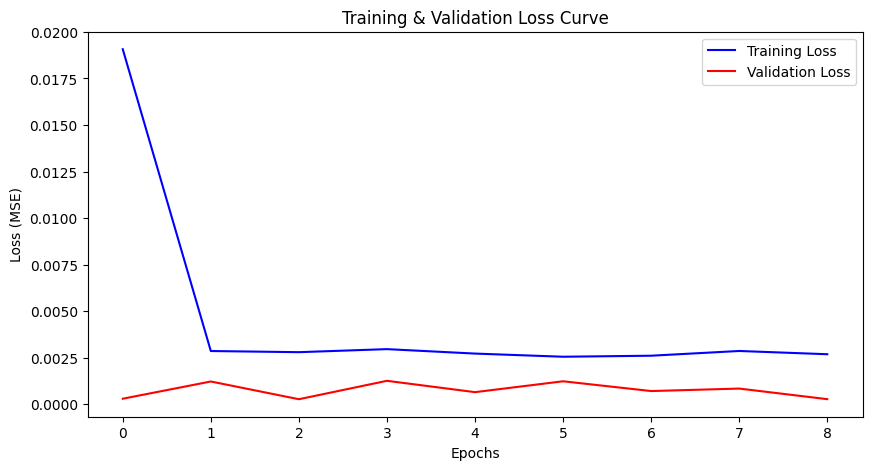

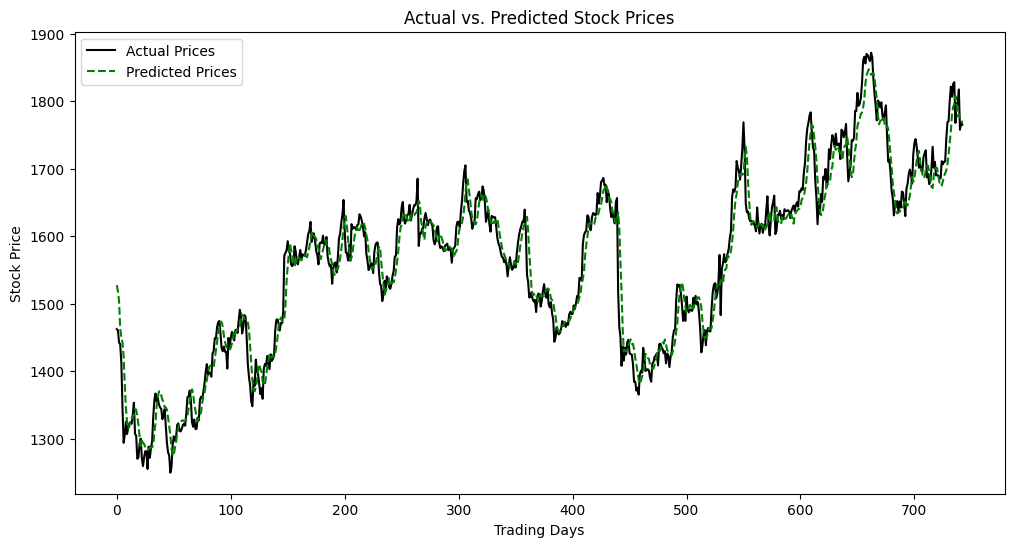

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GRU, Dense, Dropout, Multiply, Flatten, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 5
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    """Custom Attention Layer"""
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_dense = Dense(1, activation="tanh")  # Define once

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)  # Use pre-defined layer
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attention_output = Multiply()([inputs, attention_weights])
        return attention_output

# Build Hybrid CNN + Bi-GRU + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(inputs)

# Bi-GRU Layer (Captures long-term dependencies)
gru = Bidirectional(GRU(128, return_sequences=True))(cnn)

# Attention Mechanism (Focuses on important time steps)
attention = Attention()(gru)

# Fully Connected Layers
flat = Flatten()(attention)
dense1 = Dense(64, activation="relu")(flat)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0003), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_fourth_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_fourth = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth:.4f}")

# Save Model
model.save("hybrid_cnn_gru_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

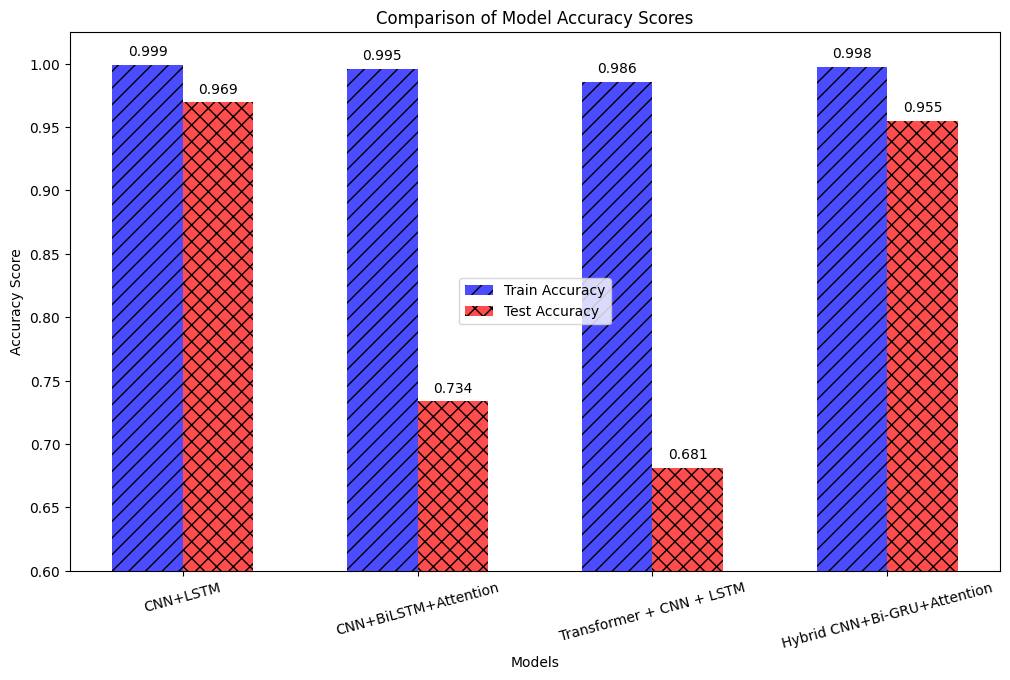

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores = {
   "CNN+LSTM": [r2_first_train, r2_first_test],
    "CNN+BiLSTM+Attention": [r2_second_train, r2_second],
    "Transformer + CNN + LSTM": [r2_third_train, r2_third],
    "Hybrid CNN+Bi-GRU+Attention": [r2_fourth_train, r2_fourth],
}

# Convert dictionary to lists
models = list(accuracy_scores.keys())
train_acc = [acc[0] for acc in accuracy_scores.values()]
test_acc = [acc[1] for acc in accuracy_scores.values()]

# Set figure size
plt.figure(figsize=(12, 7))  # Adjusted size

# Bar width
bar_width = 0.3

# X-axis positions
x = range(len(models))

# Plot bars for training and testing accuracy
plt.bar(x, train_acc, width=bar_width, label="Train Accuracy", color='b', alpha=0.7, hatch='//')
plt.bar([i + bar_width for i in x], test_acc, width=bar_width, label="Test Accuracy", color='r', alpha=0.7, hatch='xx')

# Label the accuracy values on the bars
for i in range(len(models)):
    plt.text(x[i], train_acc[i] + 0.005, f'{train_acc[i]:.3f}', ha='center', va='bottom', color='black')
    plt.text(x[i] + bar_width, test_acc[i] + 0.005, f'{test_acc[i]:.3f}', ha='center', va='bottom', color='black')

# Set labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks([i + bar_width / 2 for i in x], models, rotation=15)
plt.legend()

# Adjust y-axis to zoom in on the range of interest
plt.ylim(0.6,1.025)

# Show plot
plt.show()


# Stock:TATAMOTORS

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define stock symbol and time range
symbol = "TATAMOTORS.NS"
today = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2000)).strftime('%Y-%m-%d')

# Fetch stock data
stock_data = yf.download(symbol, start=start_date, end=today, interval="1d")

# Save or append new data
stock_data.to_csv("stock_prices.csv", mode='w', header=True)  # Overwrites existing fill

[*********************100%***********************]  1 of 1 completed


CNN+LSTM

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0104 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 6.4974e-04 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 6.2776e-04 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/100
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3436e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3377e-04 - val_loss: 5.6102e-04 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1133e-04 - val_loss: 0.0012 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7598e-04 - val_loss: 6.5060e-04 - learning_rate: 5.0000e-04
Epoch 8/100
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2863e

Testing Results:
MAE: 18.2627, MSE: 588.3978, R² Score: 0.9712


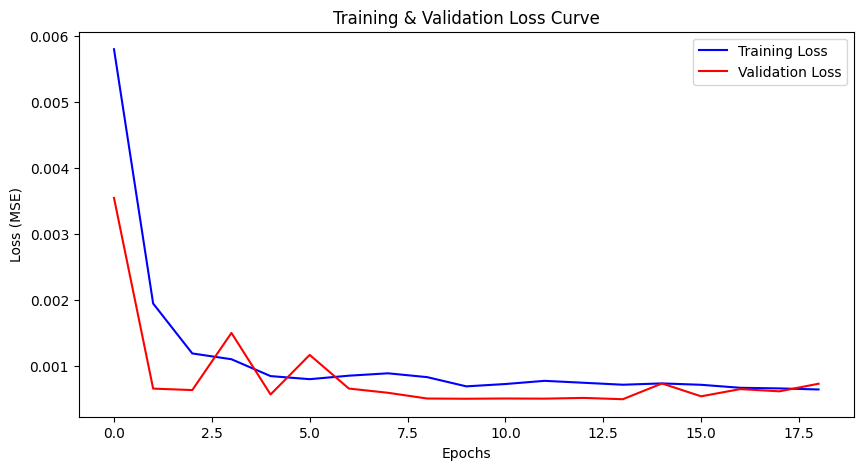

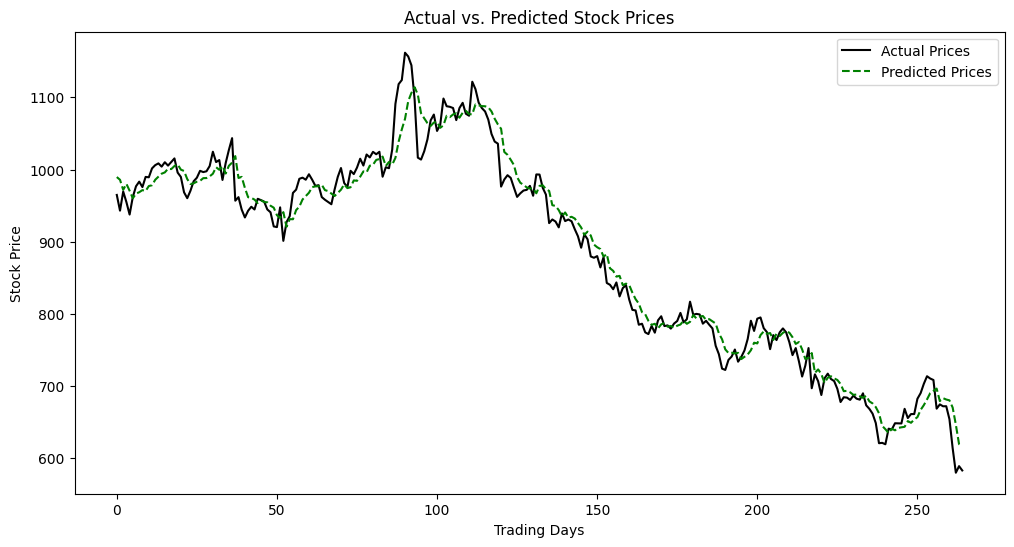

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences
timesteps = 30
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Optimized Model Architecture
model = Sequential([
    Input(shape=(timesteps, X_train.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation="relu"),
    LSTM(64, return_sequences=False),
    Dropout(0.2),  # Slightly reduced dropout
    Dense(1)
])

# Compile Model (Reverted to MSE Loss and Increased Learning Rate)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,  # Reverted batch_size to 32
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_first_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_first_test = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_test:.4f}")

# Save Model
model.save("optimized_cnn_lstm_stock_prediction_v2.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Time Period

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X_raw = df[features].values
y_raw = df[target].values

# Scale
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, x):
        score = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        weights = Softmax(axis=1)(score)
        context = Multiply()([x, weights])
        return tf.reduce_sum(context, axis=1)

# Build model function
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    cnn = Conv1D(64, 2, activation="relu")(inputs)
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)
    att = Attention()(bilstm)
    dense1 = Dense(50, activation="relu")(att)
    drop = Dropout(0.3)(dense1)
    output = Dense(1)(drop)
    model = Model(inputs, output)
    model.compile(optimizer=RMSprop(0.0005), loss="mse")
    return model

# Try different timesteps
for timestep in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - timestep):
        X_seq.append(X_scaled[i:i+timestep])
        y_seq.append(y_scaled[i + timestep])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    model = build_model((timestep, X_train.shape[2]))
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"Timestep: {timestep} | R²: {r2:.4f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Timestep: 5 | R²: 0.8079 | MAE: 48.92 | MSE: 3567.66
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 10 | R²: 0.7611 | MAE: 53.20 | MSE: 4431.78
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Timestep: 15 | R²: 0.6988 | MAE: 58.41 | MSE: 5577.54
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 20 | R²: 0.7776 | MAE: 50.61 | MSE: 4111.12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 25 | R²: 0.8842 | MAE: 36.25 | MSE: 2137.18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 30 | R²: 0.8961 | MAE: 33.44 | MSE: 1913.79
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Timestep: 35 | R²: 0.3280 | MAE: 91.08 | MSE: 12368.93
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Timestep: 40 | R²: 0.6795 | MAE: 60.66 | MSE: 5894.06
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 45 | R²: 0.5379 | MAE: 75.78 | MSE: 8484.81
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 50 | R²: 0.6399 | MAE: 65.02 | MSE: 6604.10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Timestep: 55 | R²: 0

CNN+BiLSTM+Attention

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1935 - val_loss: 0.1136 - learning_rate: 5.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0964 - val_loss: 0.0855 - learning_rate: 5.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0846 - val_loss: 0.0768 - learning_rate: 5.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0783 - val_loss: 0.1019 - learning_rate: 5.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0729 - val_loss: 0.1027 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0664 - val_loss: 0.0624 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0626 - val_loss: 0.0537 - learning_rate: 5.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0555 - val_loss: 0.0891 - learning_rate: 5.0000e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0527 - val_loss: 0.0908 - l

Testing Results:
MAE: 23.2574, MSE: 992.7929, R² Score: 0.9514


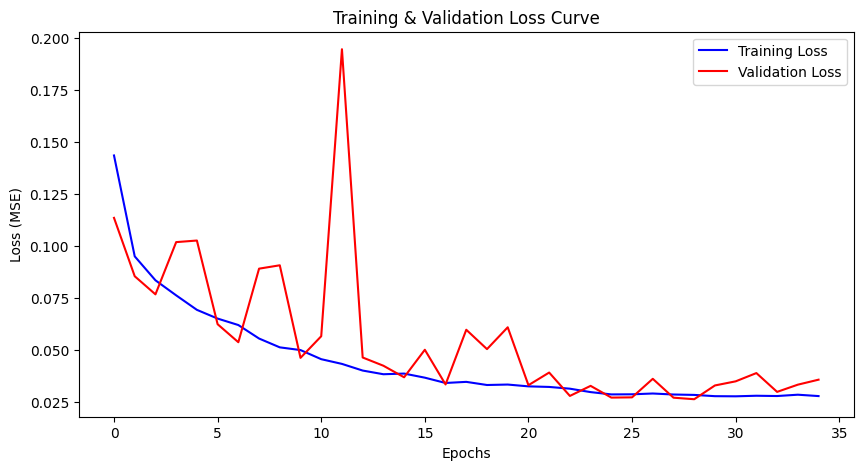

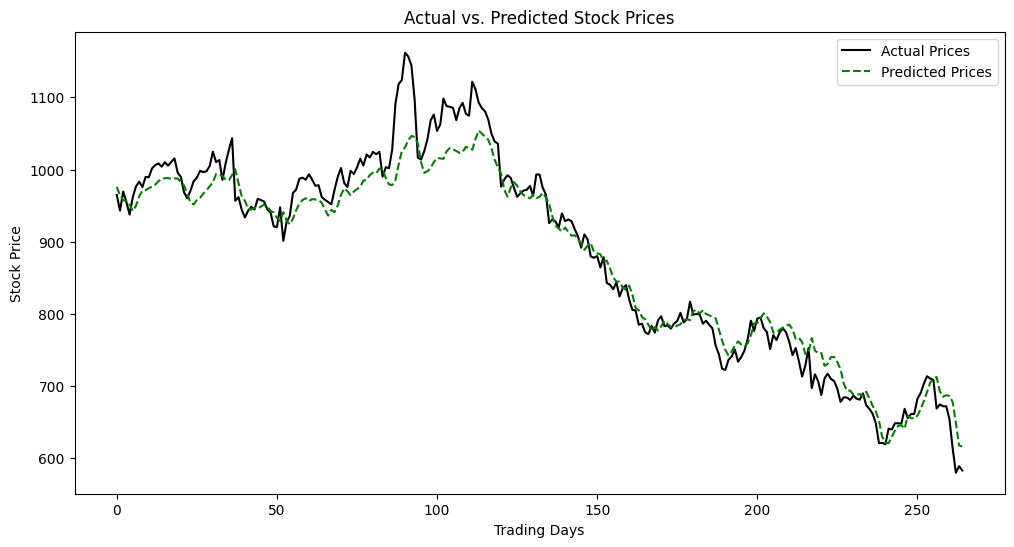

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data (Use RobustScaler to handle outliers)
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 30
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Attention Layer Function
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accepts trainable, dtype, etc.
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = Softmax(axis=1)(score)
        context_vector = Multiply()([inputs, attention_weights])
        return tf.reduce_sum(context_vector, axis=1)

# Build the Hybrid CNN + BiLSTM + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu", kernel_regularizer=l2(0.001))(inputs)

# BiLSTM Layer (Captures long-term dependencies in both directions)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Layer (Focus on important time steps)
attention = Attention()(bilstm)

# Fully Connected Layers
dense1 = Dense(50, activation="relu", kernel_regularizer=l2(0.001))(attention)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model (Using RMSprop optimizer for stability)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_second_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_second = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second:.4f}")

# Save Model
model.save("hybrid_cnn_bilstm_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Transformer + CNN + LSTM

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0408 - val_loss: 0.0058 - learning_rate: 5.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0036 - learning_rate: 5.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0084 - learning_rate: 5.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 0.0039 - learning_rate: 5.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - val_loss: 0.0054 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 0.0069 - learning_rate: 2.5000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0032 - learning_rate: 2.5000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0036 - va

Testing Results:
MAE: 45.2634, MSE: 3088.6424, R² Score: 0.8488


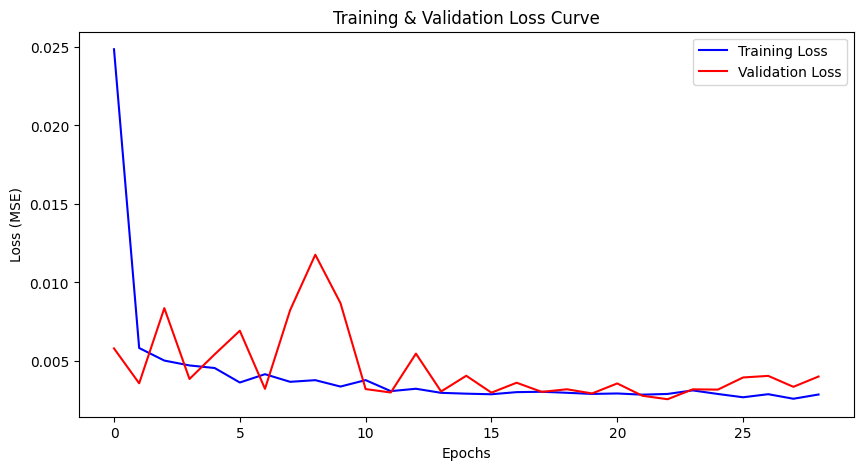

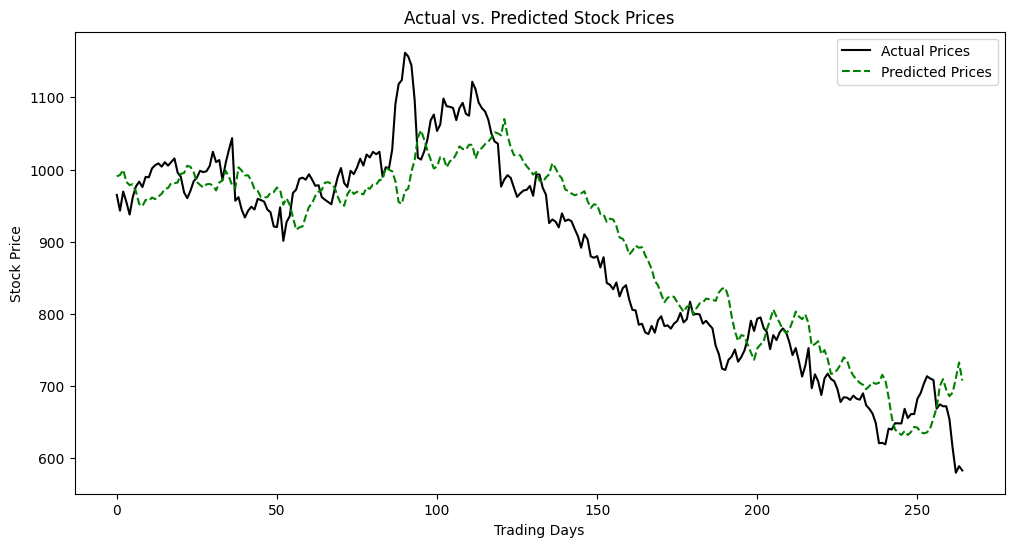

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 30
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=2, ff_dim=64):
    """Transformer Encoder Block"""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    return LayerNormalization()(ffn_output)

# Build the Hybrid Transformer + CNN + LSTM Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term features)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu")(inputs)

# Transformer Encoder Layer
transformer = transformer_encoder(cnn)

# LSTM Layer (Captures long-term dependencies)
lstm = LSTM(64, return_sequences=False)(transformer)

# Fully Connected Layers
dense1 = Dense(50, activation="relu")(lstm)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_third_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third_train:.4f}")

# Predictions & Evaluation test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_third = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third:.4f}")

# Save Model
model.save("hybrid_transformer_cnn_lstm_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0704 - val_loss: 0.0976 - learning_rate: 3.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0054 - learning_rate: 3.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - val_loss: 0.0026 - learning_rate: 3.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0021 - learning_rate: 3.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0019 - learning_rate: 3.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0049 - learning_rate: 3.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0017 - learning_rate: 3.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0025 - learning_rate: 3.0000e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0053 - 

Testing Results:
MAE: 38.0474, MSE: 2100.5699, R² Score: 0.8972


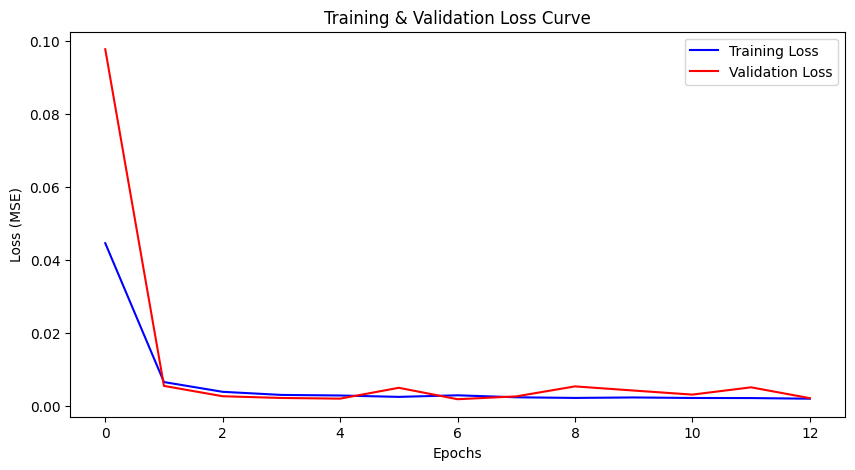

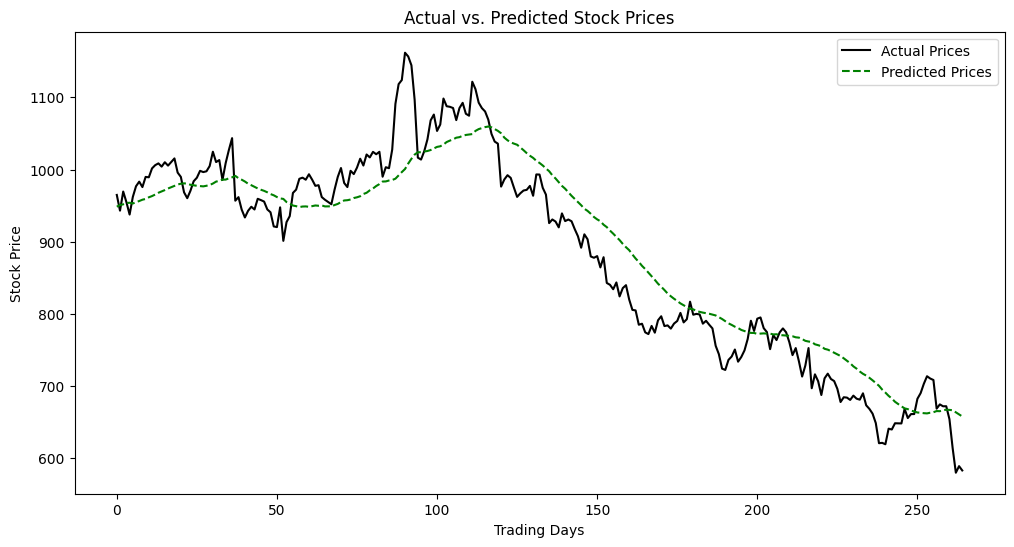

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GRU, Dense, Dropout, Multiply, Flatten, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 30
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    """Custom Attention Layer"""
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_dense = Dense(1, activation="tanh")  # Define once

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)  # Use pre-defined layer
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attention_output = Multiply()([inputs, attention_weights])
        return attention_output

# Build Hybrid CNN + Bi-GRU + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(inputs)

# Bi-GRU Layer (Captures long-term dependencies)
gru = Bidirectional(GRU(128, return_sequences=True))(cnn)

# Attention Mechanism (Focuses on important time steps)
attention = Attention()(gru)

# Fully Connected Layers
flat = Flatten()(attention)
dense1 = Dense(64, activation="relu")(flat)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0003), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_fourth_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_fourth = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth:.4f}")

# Save Model
model.save("hybrid_cnn_gru_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

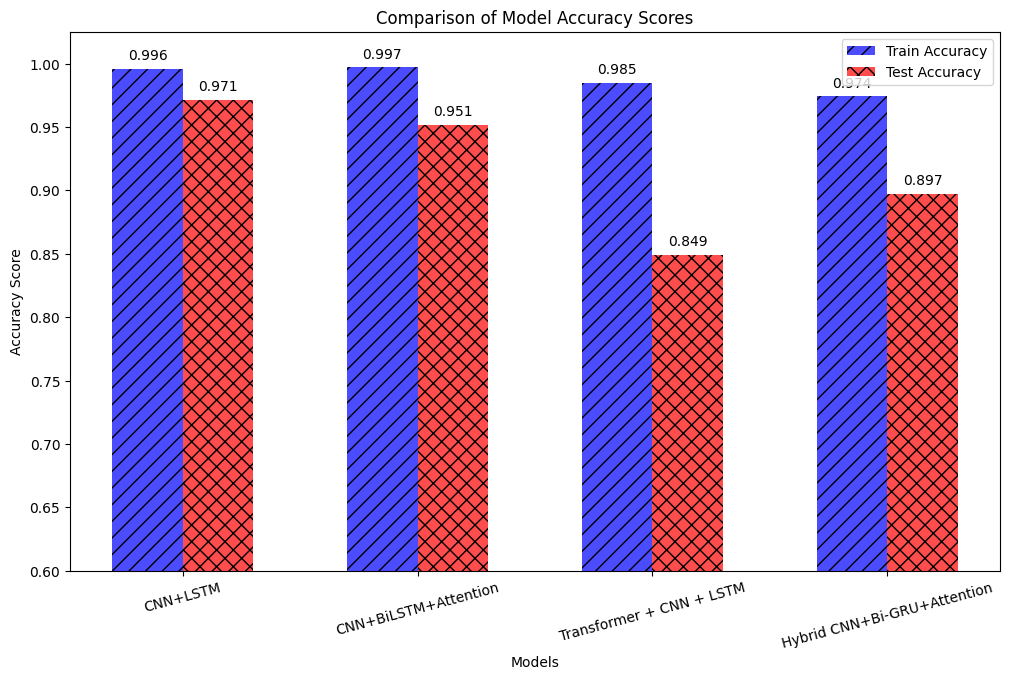

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores = {
   "CNN+LSTM": [r2_first_train, r2_first_test],
    "CNN+BiLSTM+Attention": [r2_second_train, r2_second],
    "Transformer + CNN + LSTM": [r2_third_train, r2_third],
    "Hybrid CNN+Bi-GRU+Attention": [r2_fourth_train, r2_fourth],
}

# Convert dictionary to lists
models = list(accuracy_scores.keys())
train_acc = [acc[0] for acc in accuracy_scores.values()]
test_acc = [acc[1] for acc in accuracy_scores.values()]

# Set figure size
plt.figure(figsize=(12, 7))  # Adjusted size

# Bar width
bar_width = 0.3

# X-axis positions
x = range(len(models))

# Plot bars for training and testing accuracy
plt.bar(x, train_acc, width=bar_width, label="Train Accuracy", color='b', alpha=0.7, hatch='//')
plt.bar([i + bar_width for i in x], test_acc, width=bar_width, label="Test Accuracy", color='r', alpha=0.7, hatch='xx')

# Label the accuracy values on the bars
for i in range(len(models)):
    plt.text(x[i], train_acc[i] + 0.005, f'{train_acc[i]:.3f}', ha='center', va='bottom', color='black')
    plt.text(x[i] + bar_width, test_acc[i] + 0.005, f'{test_acc[i]:.3f}', ha='center', va='bottom', color='black')

# Set labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks([i + bar_width / 2 for i in x], models, rotation=15)
plt.legend()

# Adjust y-axis to zoom in on the range of interest
plt.ylim(0.6,1.025)

# Show plot
plt.show()

# Stock:INFOSYS

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define stock symbol and time range
symbol = "INFY.NS"
today = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=3500)).strftime('%Y-%m-%d')

# Fetch stock data
stock_data = yf.download(symbol, start=start_date, end=today, interval="1d")

# Save or append new data
stock_data.to_csv("stock_prices.csv", mode='w', header=True)  # Overwrites existing fill

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


TimeSteps

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X_raw = df[features].values
y_raw = df[target].values

# Scale
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, x):
        score = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        weights = Softmax(axis=1)(score)
        context = Multiply()([x, weights])
        return tf.reduce_sum(context, axis=1)

# Build model function
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    cnn = Conv1D(64, 2, activation="relu")(inputs)
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)
    att = Attention()(bilstm)
    dense1 = Dense(50, activation="relu")(att)
    drop = Dropout(0.3)(dense1)
    output = Dense(1)(drop)
    model = Model(inputs, output)
    model.compile(optimizer=RMSprop(0.0005), loss="mse")
    return model

# Try different timesteps
for timestep in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - timestep):
        X_seq.append(X_scaled[i:i+timestep])
        y_seq.append(y_scaled[i + timestep])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    model = build_model((timestep, X_train.shape[2]))
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"Timestep: {timestep} | R²: {r2:.4f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 5 | R²: 0.9677 | MAE: 25.94 | MSE: 1124.43
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Timestep: 10 | R²: 0.9696 | MAE: 24.71 | MSE: 1054.73
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Timestep: 15 | R²: 0.9581 | MAE: 30.31 | MSE: 1449.09
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 20 | R²: 0.9709 | MAE: 24.26 | MSE: 1002.86
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Timestep: 25 | R²: 0.9468 | MAE: 34.80 | MSE: 1830.16
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 30 | R²: 0.9186 | MAE: 41.04 | MSE: 2792.12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 35 | R²: 0.9675 | MAE: 25.93 | MSE: 1112.92
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Timestep: 40 | R²: 0.9602 | MAE: 29.47 | MSE: 1360.55
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 45 | R²: 0.8918 | MAE: 52.11 | MSE: 3689.52
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 50 | R²: 0.9627 | MAE: 27.53 | MSE: 1267.59
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 55 | R²: 0.

CNN+LSTM

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0211 - val_loss: 6.8664e-04 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 9.6674e-04 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 5.3641e-04 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 8.4147e-04 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2170e-04 - val_loss: 5.1001e-04 - learning_rate: 0.0010
Epoch 6/100
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5124e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5688e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.3111e-04 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6343e

Testing Results:
MAE: 26.2046, MSE: 1100.9836, R² Score: 0.9788


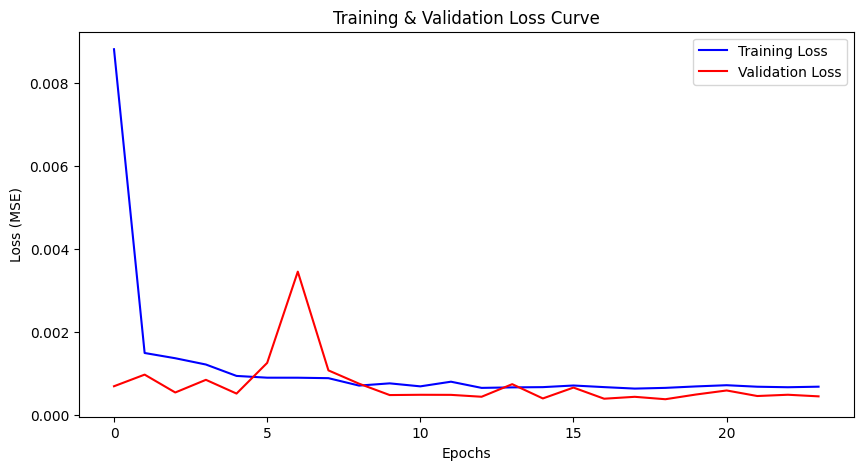

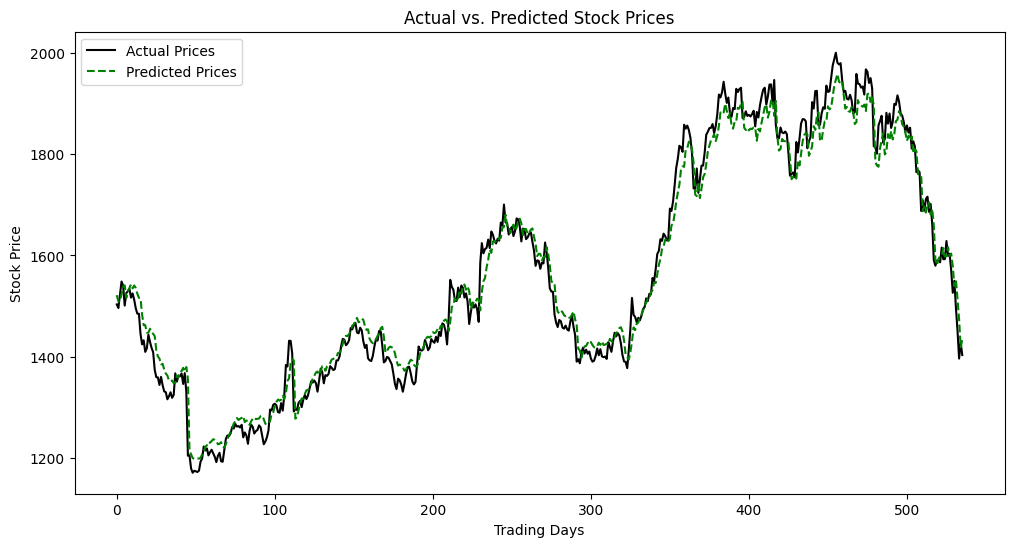

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences
timesteps = 20
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Optimized Model Architecture
model = Sequential([
    Input(shape=(timesteps, X_train.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation="relu"),
    LSTM(64, return_sequences=False),
    Dropout(0.2),  # Slightly reduced dropout
    Dense(1)
])

# Compile Model (Reverted to MSE Loss and Increased Learning Rate)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,  # Reverted batch_size to 32
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_first_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_first_test = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_test:.4f}")

# Save Model
model.save("optimized_cnn_lstm_stock_prediction_v2.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

CNN + BiLSTM + Attention

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1346 - val_loss: 0.0777 - learning_rate: 5.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0714 - val_loss: 0.0558 - learning_rate: 5.0000e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0588 - val_loss: 0.0815 - learning_rate: 5.0000e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0483 - val_loss: 0.0377 - learning_rate: 5.0000e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0398 - val_loss: 0.0327 - learning_rate: 5.0000e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0333 - val_loss: 0.0260 - learning_rate: 5.0000e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0289 - val_loss: 0.0244 - learning_rate: 5.0000e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0246 - val_loss: 0.0307 - learning_rate: 5.0000e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0207 - val_loss: 0.0216 - learning

Testing Results:
MAE: 41.2039, MSE: 2965.5704, R² Score: 0.9430


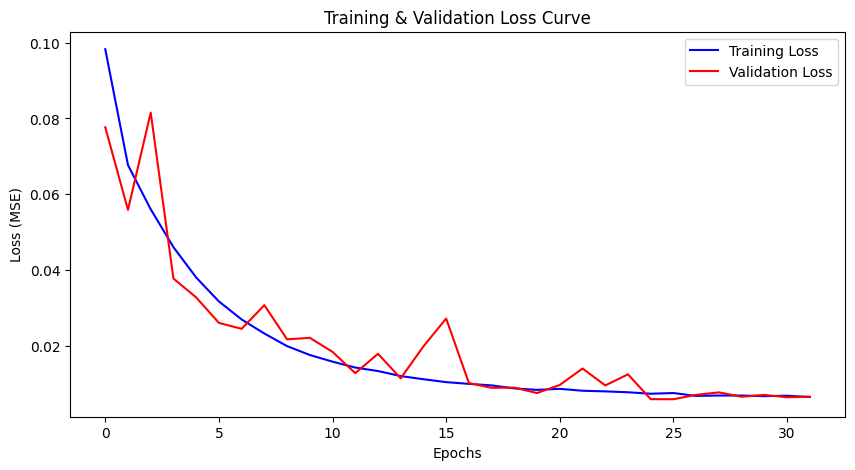

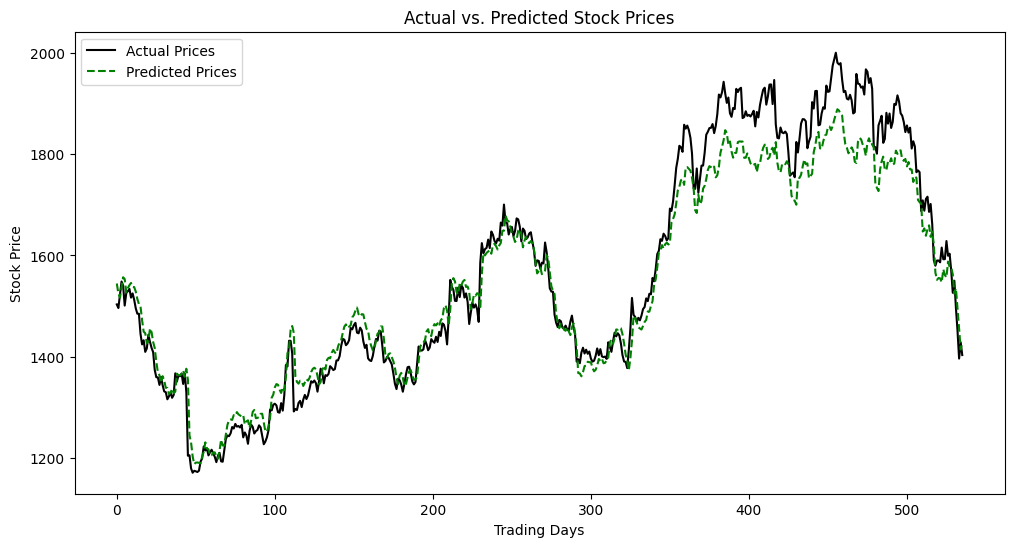

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data (Use RobustScaler to handle outliers)
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 20
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Attention Layer Function
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accepts trainable, dtype, etc.
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = Softmax(axis=1)(score)
        context_vector = Multiply()([inputs, attention_weights])
        return tf.reduce_sum(context_vector, axis=1)

# Build the Hybrid CNN + BiLSTM + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu", kernel_regularizer=l2(0.001))(inputs)

# BiLSTM Layer (Captures long-term dependencies in both directions)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Layer (Focus on important time steps)
attention = Attention()(bilstm)

# Fully Connected Layers
dense1 = Dense(50, activation="relu", kernel_regularizer=l2(0.001))(attention)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model (Using RMSprop optimizer for stability)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_second_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_second = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second:.4f}")

# Save Model
model.save("hybrid_cnn_bilstm_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Transformer + CNN + LSTM

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.1002 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0071 - val_loss: 0.0044 - learning_rate: 5.0000e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - val_loss: 0.0155 - learning_rate: 5.0000e-04
Epoch 7/100
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0055 - learning_rate: 5.0000e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val

Testing Results:
MAE: 51.3469, MSE: 4133.7589, R² Score: 0.9206


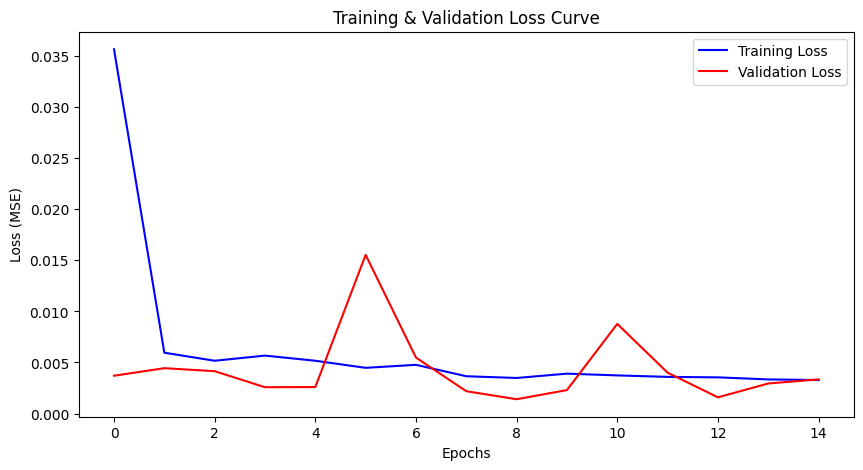

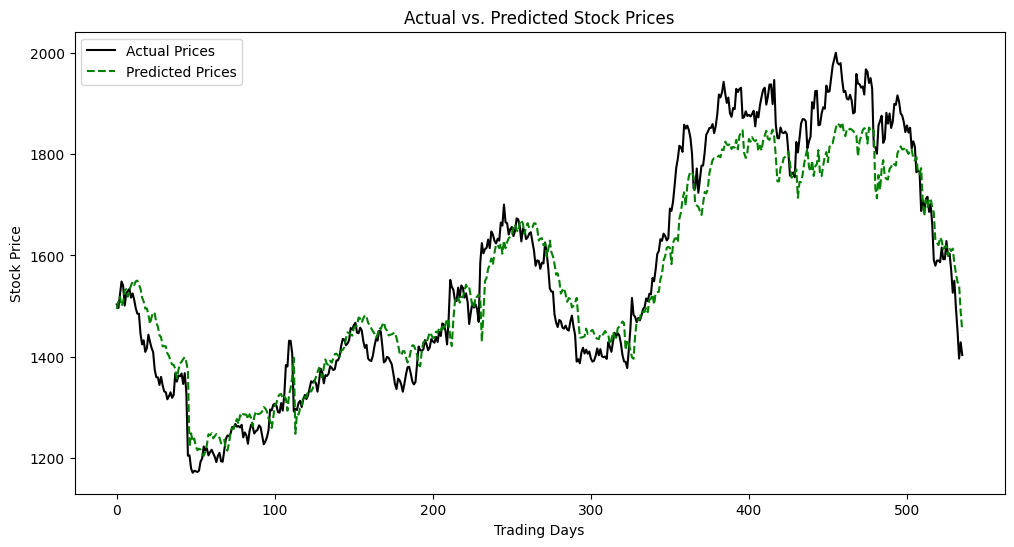

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 20
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=2, ff_dim=64):
    """Transformer Encoder Block"""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    return LayerNormalization()(ffn_output)

# Build the Hybrid Transformer + CNN + LSTM Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term features)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu")(inputs)

# Transformer Encoder Layer
transformer = transformer_encoder(cnn)

# LSTM Layer (Captures long-term dependencies)
lstm = LSTM(64, return_sequences=False)(transformer)

# Fully Connected Layers
dense1 = Dense(50, activation="relu")(lstm)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_third_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third_train:.4f}")

# Predictions & Evaluation test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_third = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third:.4f}")

# Save Model
model.save("hybrid_transformer_cnn_lstm_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

CNN + Bi-GRU + Attention

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0651 - val_loss: 0.0095 - learning_rate: 3.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 3.0000e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 0.0018 - learning_rate: 3.0000e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0019 - learning_rate: 3.0000e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0014 - learning_rate: 3.0000e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 0.0014 - learning_rate: 3.0000e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 8/100
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss

Testing Results:
MAE: 44.3247, MSE: 3083.7694, R² Score: 0.9407


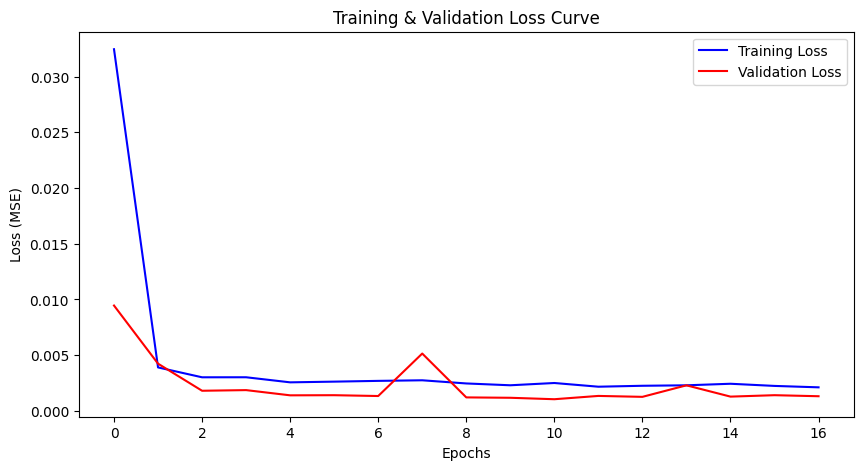

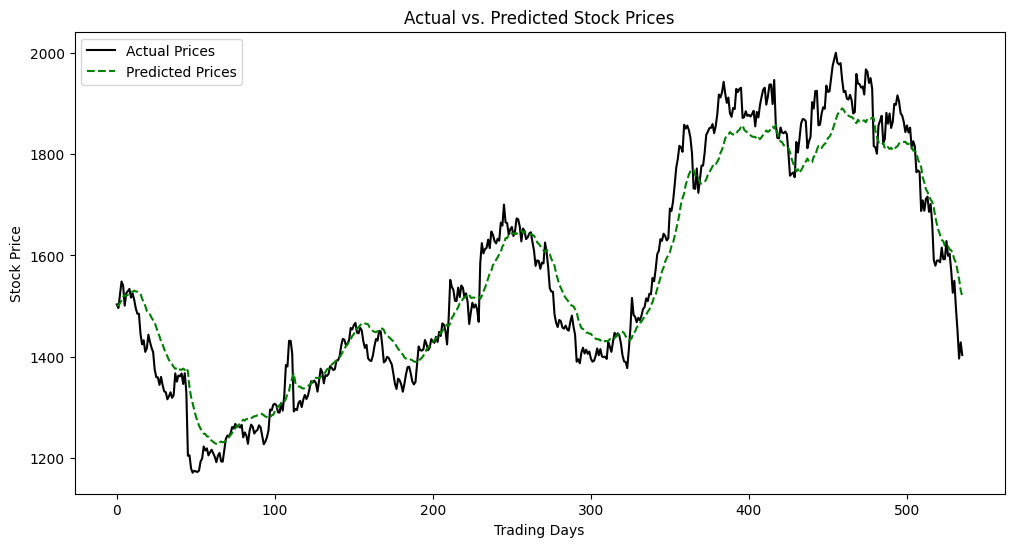

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GRU, Dense, Dropout, Multiply, Flatten, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 20 timesteps)
timesteps = 20
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    """Custom Attention Layer"""
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_dense = Dense(1, activation="tanh")  # Define once

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)  # Use pre-defined layer
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attention_output = Multiply()([inputs, attention_weights])
        return attention_output

# Build Hybrid CNN + Bi-GRU + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(inputs)

# Bi-GRU Layer (Captures long-term dependencies)
gru = Bidirectional(GRU(128, return_sequences=True))(cnn)

# Attention Mechanism (Focuses on important time steps)
attention = Attention()(gru)

# Fully Connected Layers
flat = Flatten()(attention)
dense1 = Dense(64, activation="relu")(flat)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0003), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_fourth_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_fourth = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth:.4f}")

# Save Model
model.save("hybrid_cnn_gru_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

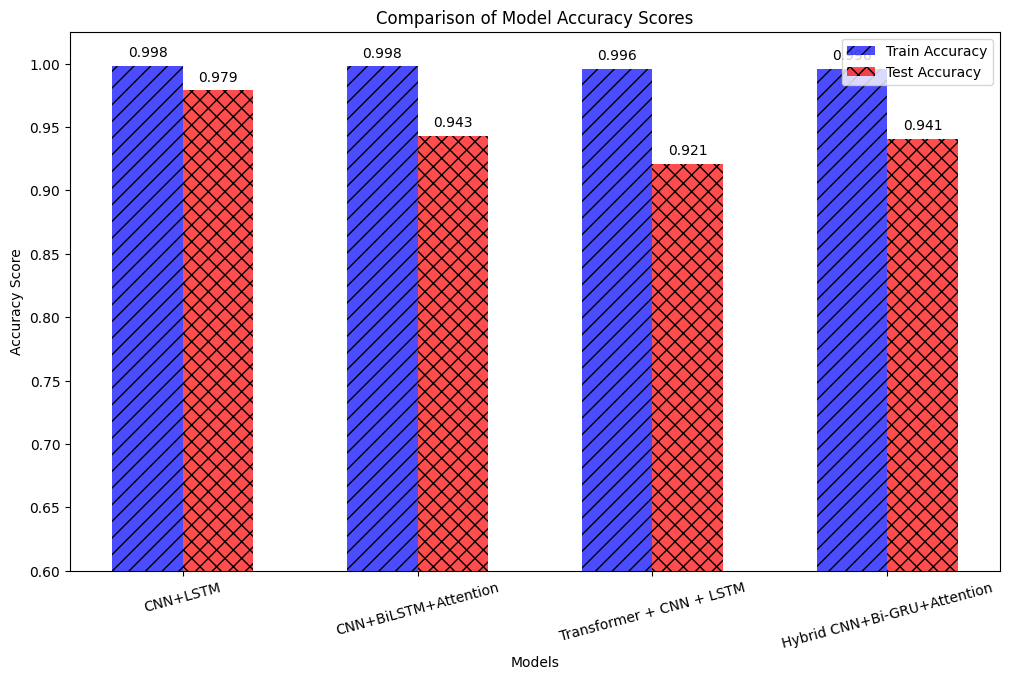

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores = {
   "CNN+LSTM": [r2_first_train, r2_first_test],
    "CNN+BiLSTM+Attention": [r2_second_train, r2_second],
    "Transformer + CNN + LSTM": [r2_third_train, r2_third],
    "Hybrid CNN+Bi-GRU+Attention": [r2_fourth_train, r2_fourth],
}

# Convert dictionary to lists
models = list(accuracy_scores.keys())
train_acc = [acc[0] for acc in accuracy_scores.values()]
test_acc = [acc[1] for acc in accuracy_scores.values()]

# Set figure size
plt.figure(figsize=(12, 7))  # Adjusted size

# Bar width
bar_width = 0.3

# X-axis positions
x = range(len(models))

# Plot bars for training and testing accuracy
plt.bar(x, train_acc, width=bar_width, label="Train Accuracy", color='b', alpha=0.7, hatch='//')
plt.bar([i + bar_width for i in x], test_acc, width=bar_width, label="Test Accuracy", color='r', alpha=0.7, hatch='xx')

# Label the accuracy values on the bars
for i in range(len(models)):
    plt.text(x[i], train_acc[i] + 0.005, f'{train_acc[i]:.3f}', ha='center', va='bottom', color='black')
    plt.text(x[i] + bar_width, test_acc[i] + 0.005, f'{test_acc[i]:.3f}', ha='center', va='bottom', color='black')

# Set labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks([i + bar_width / 2 for i in x], models, rotation=15)
plt.legend()

# Adjust y-axis to zoom in on the range of interest
plt.ylim(0.6,1.025)

# Show plot
plt.show()

# Stock:Adani Green Energy


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define stock symbol and time range
symbol = "ADANIGREEN.NS"
today = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2000)).strftime('%Y-%m-%d')

# Fetch stock data
stock_data = yf.download(symbol, start=start_date, end=today, interval="1d")

# Save or append new data
stock_data.to_csv("stock_prices.csv", mode='w', header=True)  # Overwrites existing fill

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


TimeSteps

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X_raw = df[features].values
y_raw = df[target].values

# Scale
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, x):
        score = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        weights = Softmax(axis=1)(score)
        context = Multiply()([x, weights])
        return tf.reduce_sum(context, axis=1)

# Build model function
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    cnn = Conv1D(64, 2, activation="relu")(inputs)
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)
    att = Attention()(bilstm)
    dense1 = Dense(50, activation="relu")(att)
    drop = Dropout(0.3)(dense1)
    output = Dense(1)(drop)
    model = Model(inputs, output)
    model.compile(optimizer=RMSprop(0.0005), loss="mse")
    return model

# Try different timesteps
for timestep in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - timestep):
        X_seq.append(X_scaled[i:i+timestep])
        y_seq.append(y_scaled[i + timestep])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    model = build_model((timestep, X_train.shape[2]))
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"Timestep: {timestep} | R²: {r2:.4f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 5 | R²: 0.9724 | MAE: 44.38 | MSE: 4037.99
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Timestep: 10 | R²: 0.9728 | MAE: 44.23 | MSE: 3968.47
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Timestep: 15 | R²: 0.9530 | MAE: 64.10 | MSE: 6840.73
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Timestep: 20 | R²: 0.9552 | MAE: 57.94 | MSE: 6515.33
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Timestep: 25 | R²: 0.9307 | MAE: 79.12 | MSE: 10089.13
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Timestep: 30 | R²: 0.9498 | MAE: 68.05 | MSE: 7337.43
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Timestep: 35 | R²: 0.9312 | MAE: 77.01 | MSE: 10078.79
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Timestep: 40 | R²: 0.9580 | MAE: 60.46 | MSE: 6176.68
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Timestep: 45 | R²: 0.9333 | MAE: 79.70 | MSE: 9839.54
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Timestep: 50 | R²: 0.9454 | MAE: 69.86 | MSE: 8068.75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Timestep: 55 | R²: 

CNN+LSTM

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0581 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 6.4124e-04 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 5.8080e-04 - learning_rate: 0.0010
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 6.3647e-04 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 6.5677e-04 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 5.5382e-04 - learning_rate: 5.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 

Testing Results:
MAE: 38.9724, MSE: 3452.6382, R² Score: 0.9793


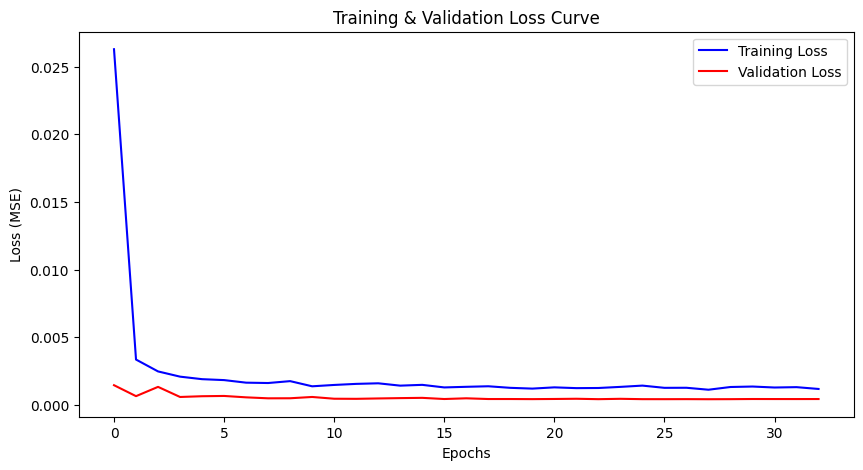

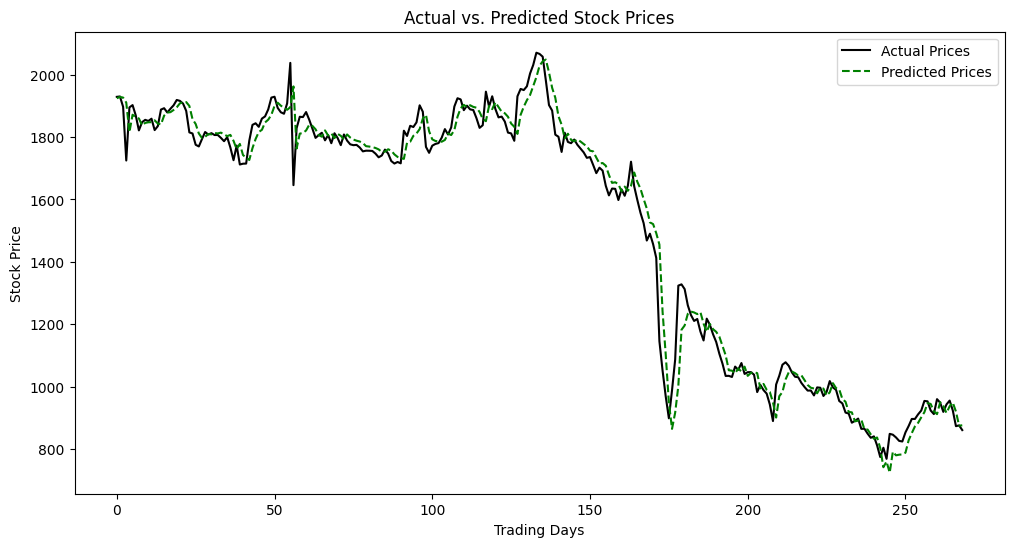

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences
timesteps = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Optimized Model Architecture
model = Sequential([
    Input(shape=(timesteps, X_train.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation="relu"),
    LSTM(64, return_sequences=False),
    Dropout(0.2),  # Slightly reduced dropout
    Dense(1)
])

# Compile Model (Reverted to MSE Loss and Increased Learning Rate)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,  # Reverted batch_size to 32
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_first_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_first_test = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_first_test:.4f}")

# Save Model
model.save("optimized_cnn_lstm_stock_prediction_v2.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

CNN + BiLSTM + Attention

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3504 - val_loss: 0.0873 - learning_rate: 5.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1112 - val_loss: 0.0795 - learning_rate: 5.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1005 - val_loss: 0.0717 - learning_rate: 5.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0897 - val_loss: 0.0666 - learning_rate: 5.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0807 - val_loss: 0.0632 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0719 - val_loss: 0.0583 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0698 - val_loss: 0.0555 - learning_rate: 5.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0636 - val_loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0618 - val_loss: 0.0455 - 

Testing Results:
MAE: 32.6404, MSE: 2921.5486, R² Score: 0.9825


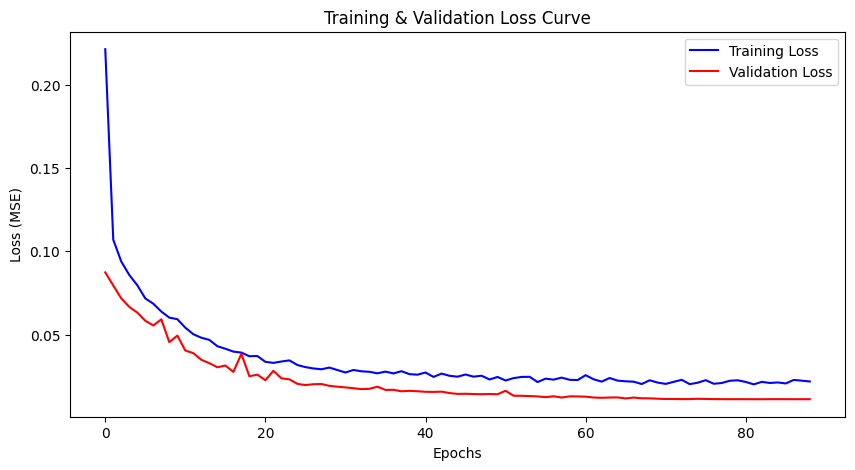

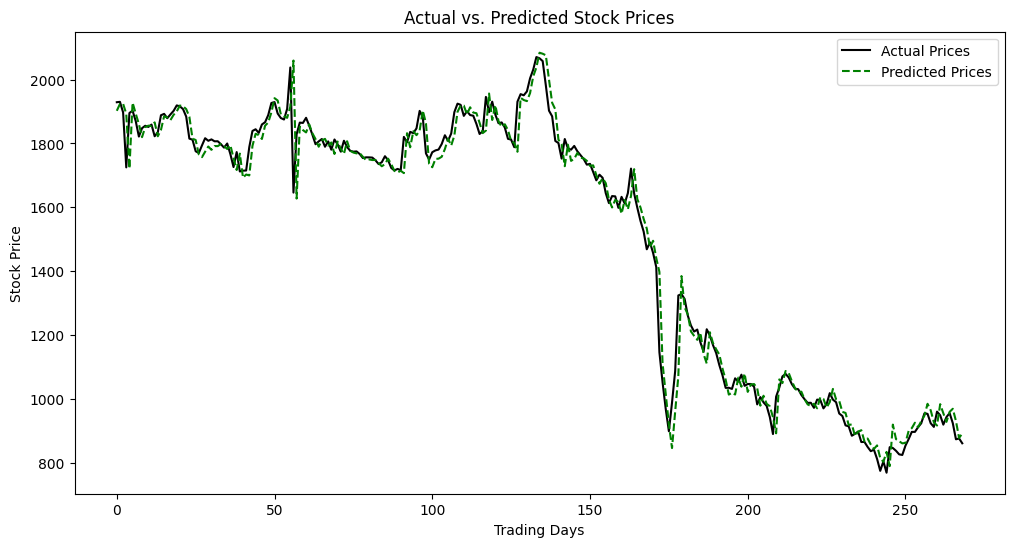

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Multiply, Softmax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data (Use RobustScaler to handle outliers)
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convert to Sequences (Using 30 timesteps)
timesteps = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Attention Layer Function
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accepts trainable, dtype, etc.
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = Softmax(axis=1)(score)
        context_vector = Multiply()([inputs, attention_weights])
        return tf.reduce_sum(context_vector, axis=1)

# Build the Hybrid CNN + BiLSTM + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu", kernel_regularizer=l2(0.001))(inputs)

# BiLSTM Layer (Captures long-term dependencies in both directions)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Layer (Focus on important time steps)
attention = Attention()(bilstm)

# Fully Connected Layers
dense1 = Dense(50, activation="relu", kernel_regularizer=l2(0.001))(attention)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model (Using RMSprop optimizer for stability)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Predictions & Evaluation Train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_second_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_second = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_second:.4f}")

# Save Model
model.save("hybrid_cnn_bilstm_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

Transformer + CNN + LSTM

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1043 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0113 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0086 - val_loss: 9.9962e-04 - learning_rate: 5.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0069 - val_loss: 9.2581e-04 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076 - val_loss: 6.6866e-04 - learning_rate: 5.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0074 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_los

Testing Results:
MAE: 48.9862, MSE: 5122.6951, R² Score: 0.9693


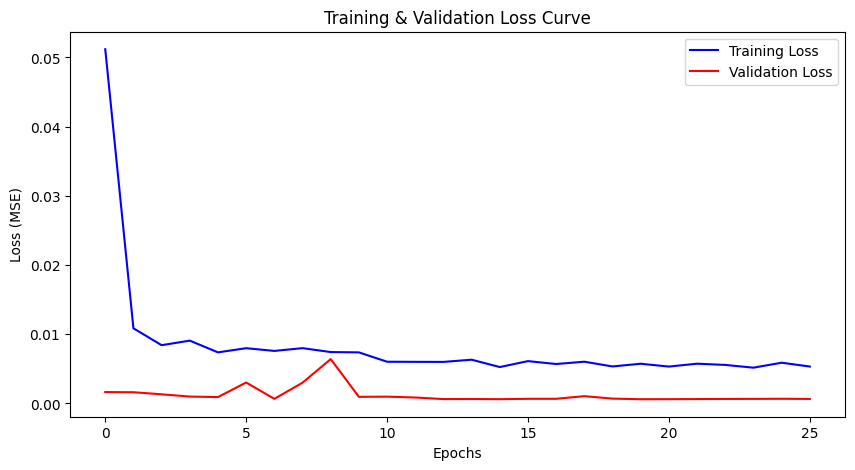

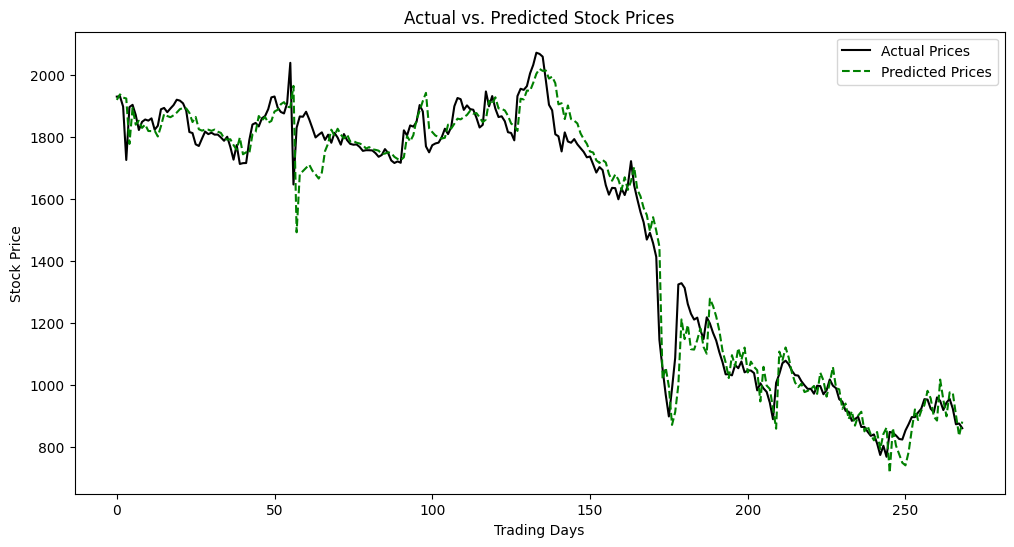

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

timesteps = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=2, ff_dim=64):
    """Transformer Encoder Block"""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    return LayerNormalization()(ffn_output)

# Build the Hybrid Transformer + CNN + LSTM Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term features)
cnn = Conv1D(filters=64, kernel_size=2, activation="relu")(inputs)

# Transformer Encoder Layer
transformer = transformer_encoder(cnn)

# LSTM Layer (Captures long-term dependencies)
lstm = LSTM(64, return_sequences=False)(transformer)

# Fully Connected Layers
dense1 = Dense(50, activation="relu")(lstm)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_third_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third_train:.4f}")

# Predictions & Evaluation test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_third = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_third:.4f}")

# Save Model
model.save("hybrid_transformer_cnn_lstm_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

CNN + Bi-GRU + Attention

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.1137 - val_loss: 0.0253 - learning_rate: 3.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0206 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0069 - val_loss: 0.0012 - learning_rate: 3.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063 - val_loss: 0.0010 - learning_rate: 3.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0062 - val_loss: 0.0011 - learning_rate: 3.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - val_loss: 0.0010 - learning_rate: 3.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - val_loss: 9.1291e-04 - learning_rate: 3.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - val_loss: 0.0016 - learning_rate: 3.0000e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0045 - val_loss: 7.910

Testing Results:
MAE: 43.7232, MSE: 4356.6732, R² Score: 0.9739


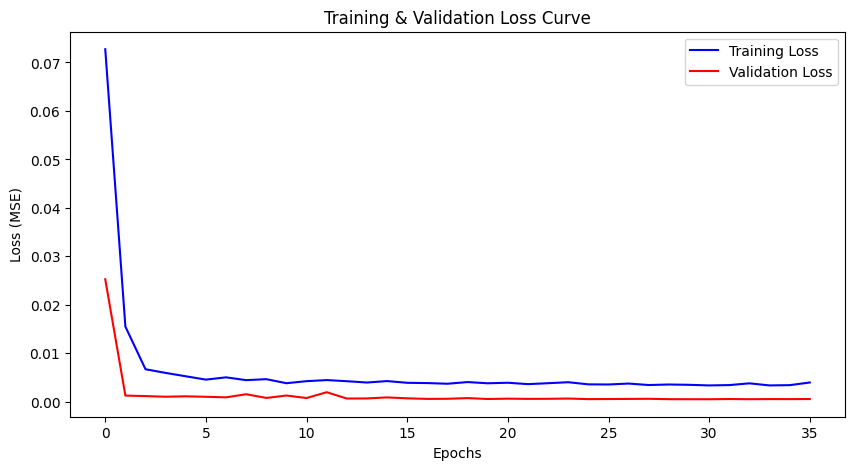

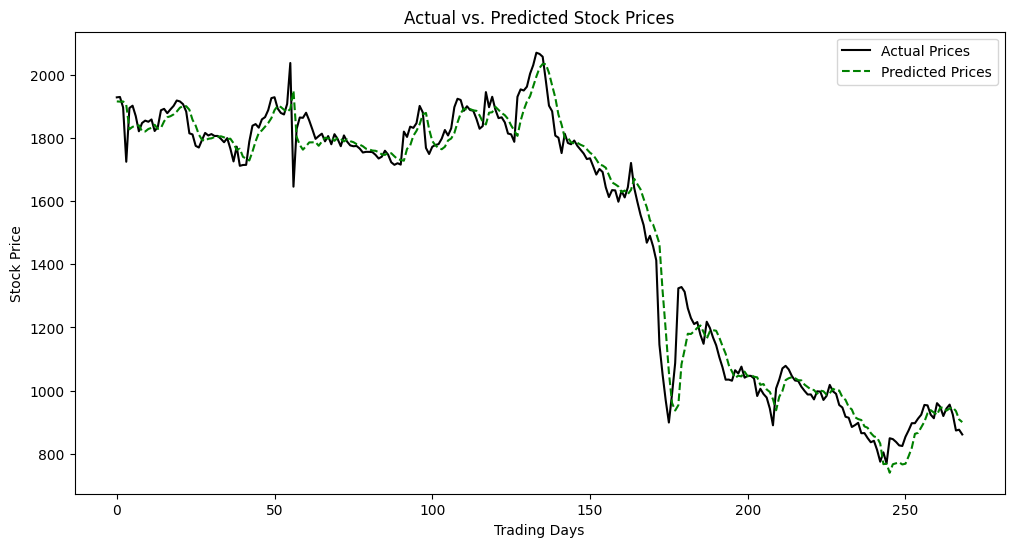

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GRU, Dense, Dropout, Multiply, Flatten, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("stock_prices.csv")
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# Feature Engineering
df["Price Change"] = df["Close"].diff()
df["Daily Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# Select Features & Target
features = ["Close", "Volume", "Price Change", "Daily Return"]
target = "Close"
X = df[features].values
y = df[target].values

# Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

timesteps = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i : i + timesteps])
    y_seq.append(y_scaled[i + timesteps])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    """Custom Attention Layer"""
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_dense = Dense(1, activation="tanh")  # Define once

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)  # Use pre-defined layer
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attention_output = Multiply()([inputs, attention_weights])
        return attention_output

# Build Hybrid CNN + Bi-GRU + Attention Model
inputs = Input(shape=(timesteps, X_train.shape[2]))

# CNN Layer (Extract short-term trends)
cnn = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(inputs)

# Bi-GRU Layer (Captures long-term dependencies)
gru = Bidirectional(GRU(128, return_sequences=True))(cnn)

# Attention Mechanism (Focuses on important time steps)
attention = Attention()(gru)

# Fully Connected Layers
flat = Flatten()(attention)
dense1 = Dense(64, activation="relu")(flat)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# Define Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0003), loss="mse")

# Callbacks for Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

#Predictions& Evaluation train
y_pred = model.predict(X_train)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_train_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
r2_fourth_train = r2_score(y_train_rescaled, y_pred_rescaled)
print("Training Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth_train:.4f}")

# Predictions & Evaluation Test
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_fourth = r2_score(y_test_rescaled, y_pred_rescaled)
print("Testing Results:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2_fourth:.4f}")

# Save Model
model.save("hybrid_cnn_gru_attention_stock_prediction.h5")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="green", linestyle="dashed")
plt.xlabel("Trading Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()

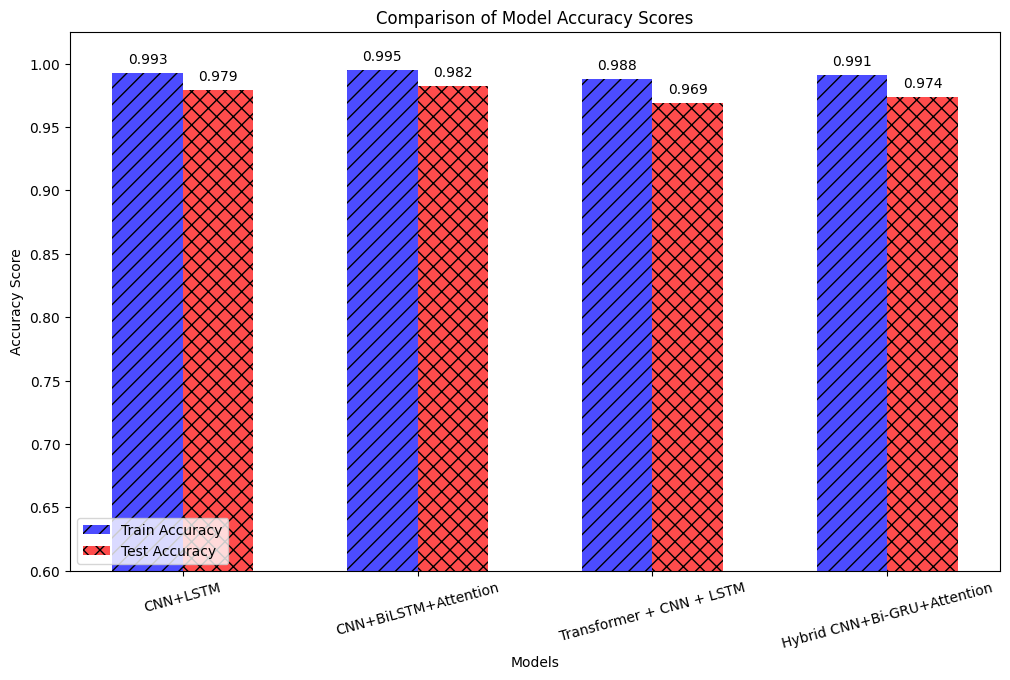

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores = {
   "CNN+LSTM": [r2_first_train, r2_first_test],
    "CNN+BiLSTM+Attention": [r2_second_train, r2_second],
    "Transformer + CNN + LSTM": [r2_third_train, r2_third],
    "Hybrid CNN+Bi-GRU+Attention": [r2_fourth_train, r2_fourth],
}

# Convert dictionary to lists
models = list(accuracy_scores.keys())
train_acc = [acc[0] for acc in accuracy_scores.values()]
test_acc = [acc[1] for acc in accuracy_scores.values()]

# Set figure size
plt.figure(figsize=(12, 7))  # Adjusted size

# Bar width
bar_width = 0.3

# X-axis positions
x = range(len(models))

# Plot bars for training and testing accuracy
plt.bar(x, train_acc, width=bar_width, label="Train Accuracy", color='b', alpha=0.7, hatch='//')
plt.bar([i + bar_width for i in x], test_acc, width=bar_width, label="Test Accuracy", color='r', alpha=0.7, hatch='xx')

# Label the accuracy values on the bars
for i in range(len(models)):
    plt.text(x[i], train_acc[i] + 0.005, f'{train_acc[i]:.3f}', ha='center', va='bottom', color='black')
    plt.text(x[i] + bar_width, test_acc[i] + 0.005, f'{test_acc[i]:.3f}', ha='center', va='bottom', color='black')

# Set labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks([i + bar_width / 2 for i in x], models, rotation=15)
plt.legend()

# Adjust y-axis to zoom in on the range of interest
plt.ylim(0.6,1.025)

# Show plot
plt.show()